In [1]:
%%time
%load_ext autoreload

from analysis_utils import *
from joblib import Parallel, delayed
import multiprocessing  
import numpy as np
import pandas as pd

#Growth rate = 3.0
#Computes the translation latencies from our model with simulations containing
#1 to 14 cognate ternary complexes in the voxel (14 to 42 not included because
#the probability of voxels with that number of cognates is ~0)
path = "/Users/Akshay/Documents/tRNAShuffle/data/"
ensmbl_latency_dict = dict()
rxndiff=dict()
scalingFactor = 200
NR_scaledrates = {'k1r':718*200/scalingFactor,'k2f':1475*200/scalingFactor,'k2r_nr':1120*200/scalingFactor,'k3_nr':6*200/scalingFactor,'k4':209*200/scalingFactor}


data = "191003_2210/"
for i in range(1,7):
    sim_i = computeTransportRxnTimes(path+data,100*(i-1),100*(i-1)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))

data = "191105_0908/"
for i in range(7,14):
    sim_i = computeTransportRxnTimes(path+data, 100*(i-1-6),100*(i-1-6)+100,cogtRNANum=i, ribosomeNum = 7,scaling=scalingFactor,NR_scaling = NR_scaledrates)
    ensmbl_latency_dict[i] = (CellLatencies(sim_i))

#Input: tRNA and codon probability distributions as well as a dictionary
#of ensemble latency dictionaries
#Returns: Elongation latencies and standard errors for each input growth rate
def computeElongationLatency(ptRNA,pCodon,ensmbl_latency_dict):
    transportRxnResults = transportRxnCalc(ptRNA,pCodon,ensmbl_latency_dict)
    rxndiff['30'] = transportRxnResults[1:]
    
    #The added scalar values are the average reaction latencies following succesful reaction
    return([rxndiff[d][2][0]+(1000/1475+1000/1529+1000/209+1000/200+1000/32) for d in rxndiff],[rxndiff[d][5][0] for d in rxndiff])

Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
Computing...
CPU times: user 53.1 s, sys: 668 ms, total: 53.7 s
Wall time: 54.8 s


In [2]:
#Experimentally obtained codon usage frequencies and tRNA abundances at growth rate = 2.5 dbl/hr
gr25_Codon = np.array([2.36, 1.26, 45.55, 34.17, 16.97, 57.86, 19.27, 33.74, 14.98, 22.31, 43.18, 7.67, 24.11, 24.87, 39.49, 11.81, 0.03, 0.63, 2.19, 9.31, 17.22, 55.01, 5.61, 29.21, 21.67, 0.52, 15.79, 43.86, 4.17, 2.61, 20.64, 26.7, 7.03, 0.19, 2.76, 3.81, 6.72, 16.52, 4.27, 2.73, 7.92, 23.25, 2.51, 1.98, 16.33, 11.68, 0.62, 0.67, 43.82, 20.59, 27.28, 7.01, 6.78, 14.21, 60.75, 0.82, 3.86, 4.09, 28.82, 5.18, 4.38, 1.09])
gr25_pCodon = gr25_Codon/np.sum(gr25_Codon)
gr25_ptRNA = [0.0602409638554217, 0.010542168674698798, 0.07379518072289158, 0.00602409638554217, 0.010542168674698798, 0.00602409638554217, 0.021084337349397596, 0.043674698795180725, 0.021084337349397596, 0.01204819277108434, 0.01807228915662651, 0.08433734939759038, 0.03162650602409639, 0.07228915662650603, 0.01204819277108434, 0.07078313253012049, 0.06325301204819278, 0.01656626506024097, 0.009036144578313254, 0.027108433734939763, 0.010542168674698798, 0.03012048192771085, 0.013554216867469882, 0.015060240963855425, 0.0075301204819277125, 0.010542168674698798, 0.0075301204819277125, 0.003012048192771085, 0.021084337349397596, 0.004518072289156627, 0.01656626506024097, 0.01204819277108434, 0.0015060240963855425, 0.009036144578313254, 0.01656626506024097, 0.019578313253012052, 0.015060240963855425, 0.027108434, 0.05873493975903616, 0.019578313]
gr25_ptRNA = gr25_ptRNA/np.sum(gr25_ptRNA)

In [3]:
#Compute elongation latency for uniform codon with WT tRNA
pCodon_uniform = np.ones(len(gr25_pCodon))/sum(np.ones(len(gr25_pCodon)))

#List of synonymous codons based on codon label order
syn_codon_list = [[0,1,2,3],[4,5],[6,7],[8,9,10,11],[12,13,14,15],[16,17,46,47,48,49],[18,19,42,43,44,45],
              [20,21],[22,23],[24],[25,26,27],[28,29,30,31],[32],[33],[34,35],[36,37],[38,39,54,55,56,57],[40,41],
              [50,51],[52,53],[58,59,60,61]]
syn_codon_freqs = list()
for syn_codons in syn_codon_list:
    syn_codon_freqs.append(sum(gr25_pCodon[syn_codons]))
    pCodon_uniform[syn_codons] = sum(gr25_pCodon[syn_codons])/sum(pCodon_uniform[syn_codons])*pCodon_uniform[syn_codons]
pCodon_uniform = pCodon_uniform/np.sum(pCodon_uniform)

elongt_WTtRNA_uniformcodon, std = computeElongationLatency(gr25_ptRNA,pCodon_uniform,ensmbl_latency_dict)

209.49884630130458 4.087740673381316
z-score:  5.650761177615889
p-value 7.986944833731715e-09


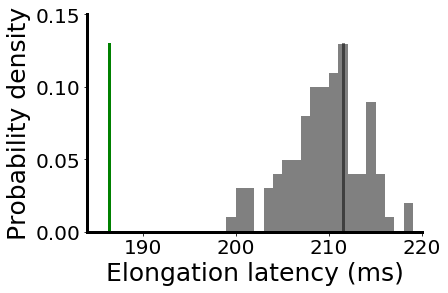

In [5]:
#### Plot tRNA shuffling
import matplotlib.pyplot as plt
import scipy.stats

p_tRNA_list=np.load('./data/RandomtRNA_FixedCodon_100sample_ptRNA.npy')
elong_t_tRNA_list=np.load('./data/RandomtRNA_FixedCodon_100sample_elong_t.npy')

fig,ax = plt.subplots(1,1)
hist=ax.hist(elong_t_tRNA_list,20,color='grey',density=True)
ax.plot([186.4]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='green')
ax.plot([211.5]*100,np.linspace(0,max(hist[0]),100),linewidth=3,color='black',alpha=0.5)

print(np.mean(elong_t_tRNA_list), np.std(elong_t_tRNA_list))
print('z-score: ', (np.mean(elong_t_tRNA_list)-186.4)/np.std(elong_t_tRNA_list))
print('p-value', scipy.stats.norm.sf(abs((np.mean(elong_t_tRNA_list)-186.4)/np.std(elong_t_tRNA_list))))
for _,axes in enumerate([ax]):
    axes.spines['left'].set_linewidth(3)
    axes.spines['bottom'].set_linewidth(3)
    axes.spines['top'].set_linewidth(0)
    axes.spines['right'].set_linewidth(0)
    axes.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylim(0,0.15)
    ax.set_xlim(184,220)
    ax.set_xlabel('Elongation latency (ms)',size=25)
    ax.set_ylabel('Probability density',size=25)